## Step 1: Intializing the asset to forecast
- **Read CSV**: to load the historical data into the dataframe

In [135]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

asset_list = ['AAPL']
folder_path = "..\Data Collection & Processing\historical_prices_data" 
forecasts_folder = "..\Data Collection & Processing\stock_forecasts"
performance_folder = "..\Data Collection & Processing\stock_performance"

for asset in asset_list: 
  file_path = os.path.join(folder_path, f"{asset}.csv")
  # Import the top 25 sp500 stocks dataset into a Pandas Dataframe
  df = pd.read_csv(
    file_path,  
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
  )
  


- **Change the Date column to be the index**: Verify the dataframe with the correct columns

In [136]:
df = df.reset_index()
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-02-11,18.950357,19.205357,18.910713,19.141430,16.860064,282256800
1,2014-02-12,19.176786,19.270000,19.044287,19.139999,16.858810,308100800
2,2014-02-13,19.094999,19.458929,19.078571,19.443930,17.126516,307398000
3,2014-02-14,19.373928,19.499287,19.328930,19.428213,17.112673,272924400
4,2014-02-18,19.500000,19.685356,19.486071,19.499643,17.175587,260251600
...,...,...,...,...,...,...,...
2512,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.440811,69668800
2513,2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800
2514,2024-02-07,190.639999,191.050003,188.610001,189.410004,189.168625,53439000
2515,2024-02-08,189.389999,189.539993,187.350006,188.320007,188.080017,40962000


- **Filter relevant columns**: Only date and close columns are needed for prophet model 

In [137]:
df = df.filter(['Date','Close'])
df.head()

,Date,Close
0,2014-02-11,19.141430
1,2014-02-12,19.139999
2,2014-02-13,19.443930
3,2014-02-14,19.428213
4,2014-02-18,19.499643


- **Filter out any negative values**: to clean the data before training the model for prediction to avoid inaccurate predictions

In [138]:
# To filter negative values
df.index[df['Close'] < 0]

Int64Index([], dtype='int64')

- **Visualise the close price trend**: to understand the stock price movement

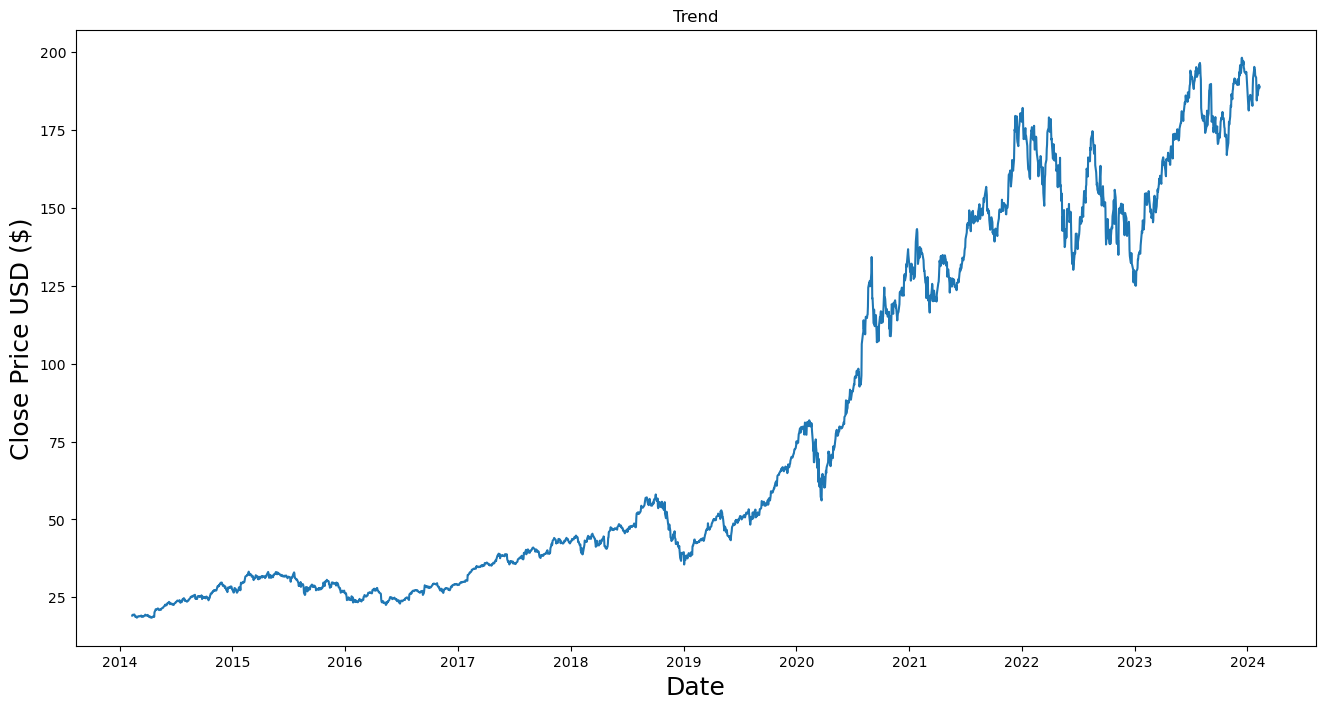

In [139]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'], df['Close'])
plt.title('Trend')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Step 2: Converting the data to stationery

Because financial time series are not stationary because they tend to have trends (increasing or decreasing over time) and most time series models assume that the data is stationary.

yt = yt-y(t-1) is used to calculate the difference between the closing price of a stock on a given day and the closing price from the previous day,which helps to stabilize the mean of the time series by removing changes in the level of a time series, and thus trend and seasonality, which can lead to achieving stationarity.




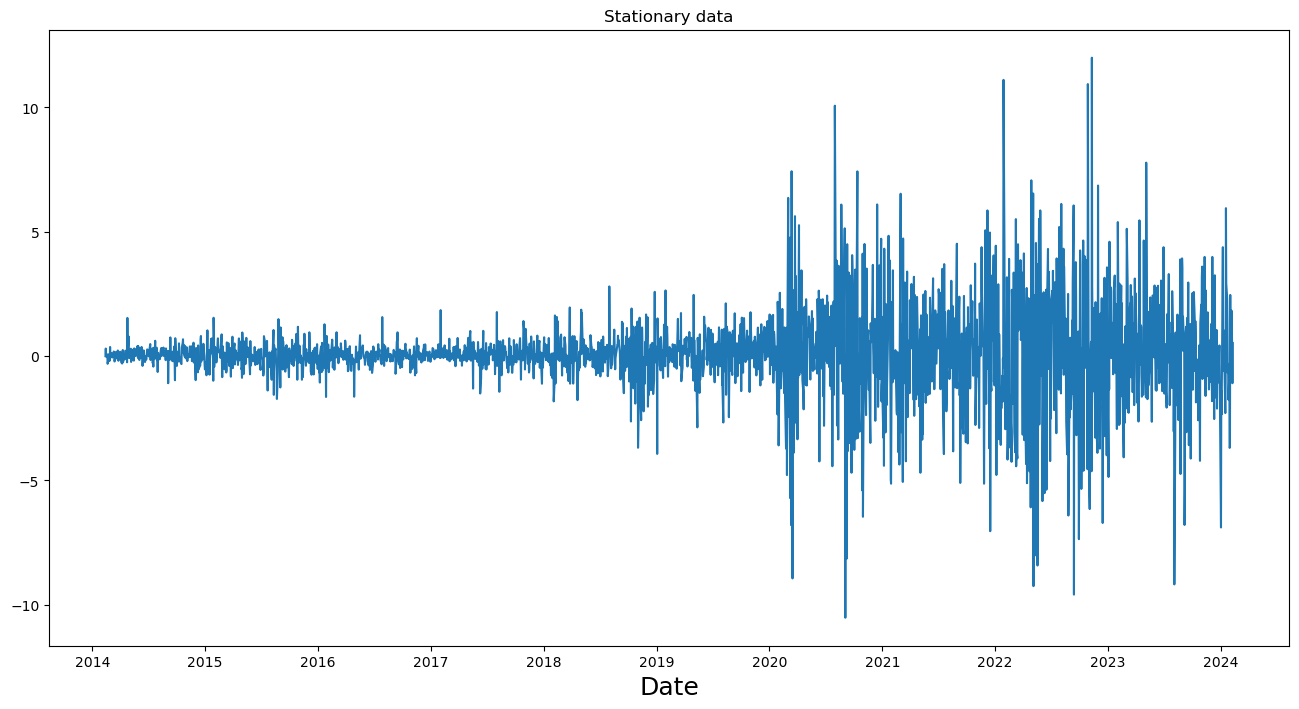

In [140]:
# yt = yt-y(t-1) - First differencing formula to convert the data into stationary
df['Close Shift'] = df['Close'].diff()
y = df['Close Shift']

plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close Shift'])
plt.title('Stationary data')
plt.xlabel('Date', fontsize=18)
plt.show()

- **Verify the columns**: to ensure the the price change column (Close Shift) from one day to the next is present

In [141]:
df.columns

Index(['Date', 'Close', 'Close Shift'], dtype='object')

- **Rename the columns**: because prophet model need a data fram to have ds which is the date and y which is the measurement to be forecasted

In [142]:
prophet_df = df.rename(columns = {'Date' : 'ds', 'Close Shift' : 'y'})

  # Sort the DataFrame by `ds` in ascending order
prophet_df = prophet_df.sort_values('ds', ascending = True)

display(prophet_df)

,ds,Close,y
0,2014-02-11,19.141430,NaN
1,2014-02-12,19.139999,-0.001431
2,2014-02-13,19.443930,0.303930
3,2014-02-14,19.428213,-0.015717
4,2014-02-18,19.499643,0.071430
...,...,...,...
2512,2024-02-05,187.679993,1.829987
2513,2024-02-06,189.300003,1.620010
2514,2024-02-07,189.410004,0.110001
2515,2024-02-08,188.320007,-1.089996


## Step 3: Preparing the data for training the model

- **Split the data**: 80% to be used for training which is 2013 rows

In [143]:
## Split the Data
train_data_len = int(0.8*len(df))
train_data_len

2013

- **Check the train and test data split**: verify that there are no overlapping dates and it is split accordingly. 2013 for training and 504 for testing

In [144]:
#80% for training and 20% for testing
df_train = prophet_df[:train_data_len]
df_test = prophet_df[train_data_len:]
display(df_train, df_train.shape)
display(df_test, df_test.shape)

,ds,Close,y
0,2014-02-11,19.141430,NaN
1,2014-02-12,19.139999,-0.001431
2,2014-02-13,19.443930,0.303930
3,2014-02-14,19.428213,-0.015717
4,2014-02-18,19.499643,0.071430
...,...,...,...
2008,2022-02-01,174.610001,-0.169998
2009,2022-02-02,175.839996,1.229996
2010,2022-02-03,172.899994,-2.940002
2011,2022-02-04,172.389999,-0.509995


(2013, 3)

,ds,Close,y
2013,2022-02-08,174.830002,3.169998
2014,2022-02-09,176.279999,1.449997
2015,2022-02-10,172.119995,-4.160004
2016,2022-02-11,168.639999,-3.479996
2017,2022-02-14,168.880005,0.240005
...,...,...,...
2512,2024-02-05,187.679993,1.829987
2513,2024-02-06,189.300003,1.620010
2514,2024-02-07,189.410004,0.110001
2515,2024-02-08,188.320007,-1.089996


(504, 3)

- **Training the model**:

To initialize and fit a forecasting model using Prophet. The model is created with `changepoint_prior_scale=0.01` and `seasonality_prior_scale=0.01`, settings that make the model conservative in detecting trend changes and seasonal variations, ideal for stable series. The model is then trained on the `df_train` dataset, which must contain `ds` (date column) and `y` (values column), allowing the model to learn from historical data and predict future values accurately.


In [145]:
model = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=0.01)

# Fit the Prophet model.
model.fit(df_train)

23:15:46 - cmdstanpy - INFO - Chain [1] start processing
23:15:46 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
periods = len(df)-len(df_train)
periods

504

- **To prepare a dataframe with the dates for prediction**:generates a new DataFrame called forecast that extends beyond the historical data you've used to train the model. The periods=504 parameter tells Prophet that you want to create a future dataframe for 504 days ahead of the last date in your training dataset (df_train).

In [147]:
forecast = model.make_future_dataframe(periods= periods)
display(forecast)

,ds
0,2014-02-11
1,2014-02-12
2,2014-02-13
3,2014-02-14
4,2014-02-18
...,...
2512,2023-06-22
2513,2023-06-23
2514,2023-06-24
2515,2023-06-25


- **Make predictions for the forecast dates**:  the yhat represents the predicted value which is the price change from one day to the next day

In [148]:
# Make Prediction 
prediction = model.predict(forecast)

display(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2014-02-11,-0.049872,-1.792705,1.569967
1,2014-02-12,-0.064913,-1.848677,1.740731
2,2014-02-13,-0.190394,-1.946160,1.477689
3,2014-02-14,-0.187096,-1.905788,1.516784
4,2014-02-18,-0.138260,-1.848082,1.390422
...,...,...,...,...
2512,2023-06-22,0.191584,-1.494456,1.902274
2513,2023-06-23,0.215111,-1.401418,1.867545
2514,2023-06-24,0.305092,-1.373324,1.918709
2515,2023-06-25,0.311137,-1.345727,2.131391


- **Plot the predictions**:  

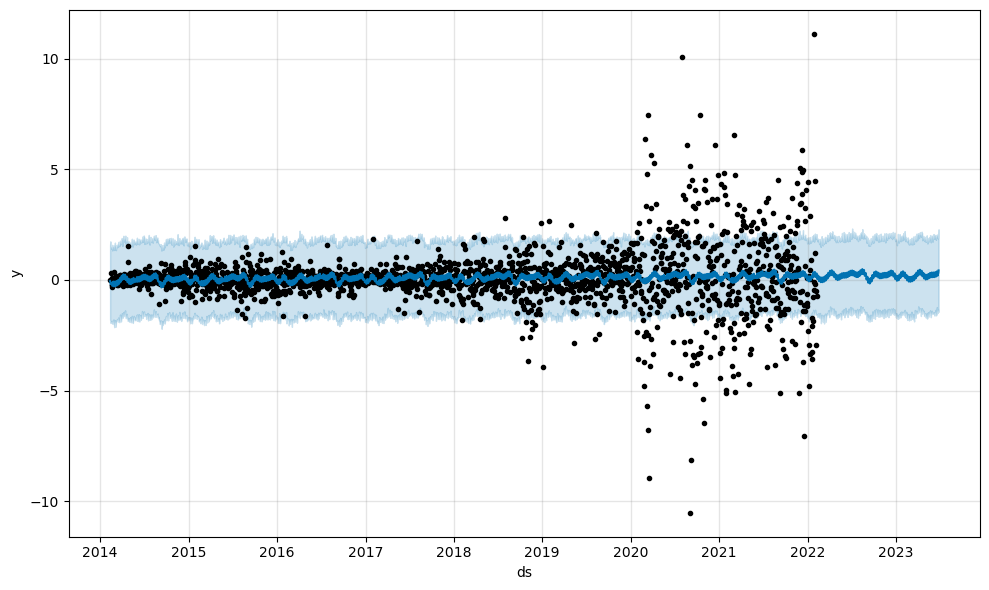

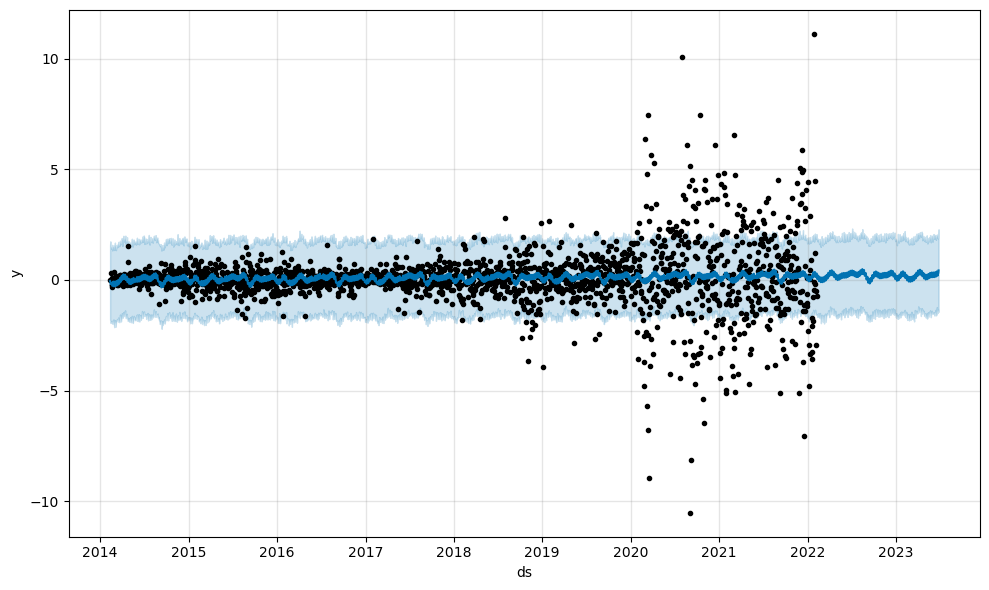

In [149]:

# Plot Our Predictions
model.plot(prediction)

##### Analysis & Conclusion
The graph showcases a time series forecast using the Prophet model, plotting predicted median daily stock price changes (blue line) against actual data (black dots) from 2014 to 2023. The blue line indicates the model's estimated trend, which remains relatively stable around zero, highlighting no significant long-term increases or decreases in the data. Surrounding this trend line, the light blue shaded area denotes the confidence intervals, which slightly broaden over time, pointing to increasing uncertainty in future predictions. Notably, the data from recent years (2021-2023) shows greater dispersion and some outliers, suggesting a potential increase in volatility or the impact of specific events on the data.,

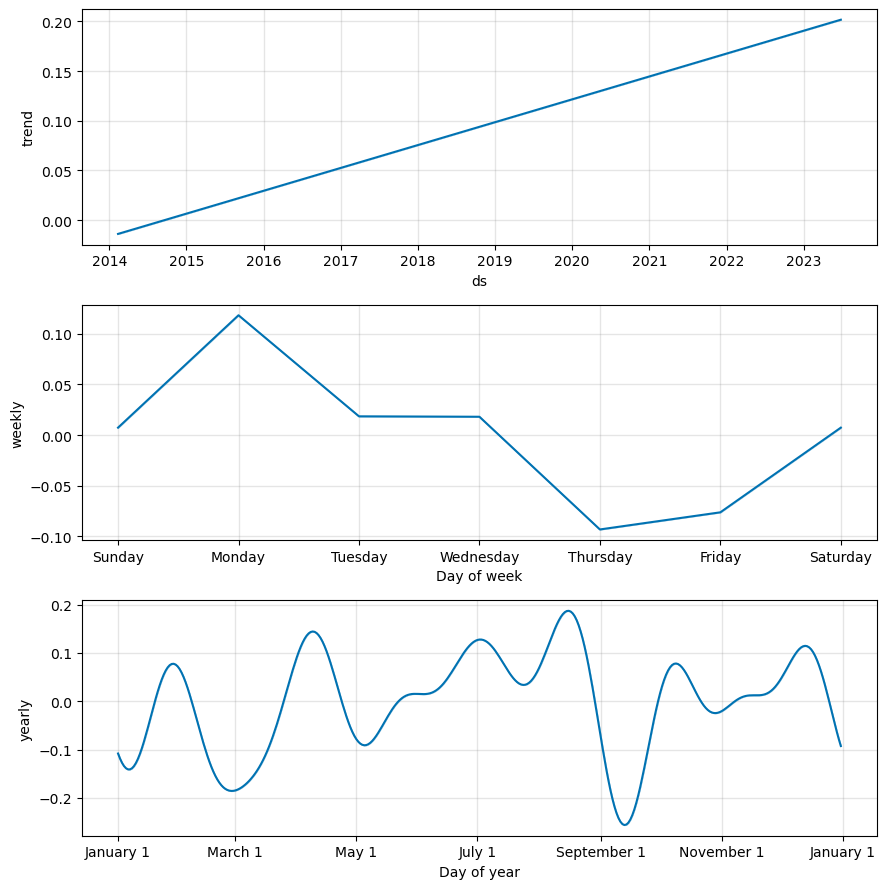

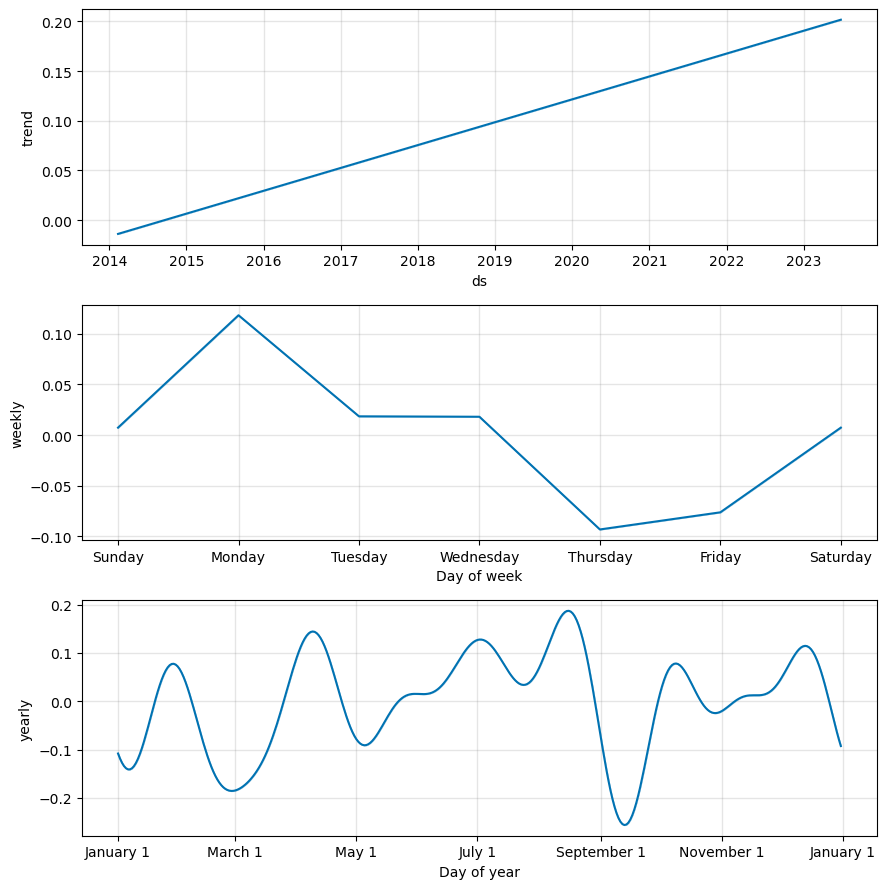

In [150]:

model.plot_components(prediction)

##### Analysis
The provided graph from the Prophet model breakdown illustrates three key components: trend, weekly seasonality, and yearly seasonality, offering insights into the underlying patterns of the time series data:

##### Trend Component
- **Graph**: The top panel
- **Analysis**: Displays a consistent upward trajectory from 2014 to 2023. This indicates steady growth over time, which could be related to metrics such as increasing sales, user engagement, or stock prices.

##### Weekly Seasonality
- **Graph**: The middle panel
- **Analysis**: 
  - Shows distinct patterns depending on the day of the week.
  - **Peak**: Monday appears to be the highest point, suggesting significant activity or changes at the start of the week.
  - **Trough**: Wednesday shows the lowest points, indicating a mid-week dip in activity.
  - This could be crucial for operational planning, like staffing or marketing strategies, to capitalize on or counteract these weekly trends.

##### Yearly Seasonality
- **Graph**: The bottom panel
- **Analysis**:
  - Exhibits clear cyclic patterns throughout the year with noticeable peaks and troughs.
  - **Highs**: Peaks in July and early November might correspond with seasonal business cycles, promotional events, or other significant activities.
  - **Lows**: Dips in March and September could indicate periods of reduced activity.
  - Understanding these patterns can help in setting annual strategies for inventory, resource allocation, and marketing.

## Step 4: Measuring the forecast error

### Cross Validation

In [151]:
## prepare diagnostics report
from prophet.diagnostics import cross_validation
df_train.shape, len(df)-len(df_train)

((2013, 3), 504)

##### This function performs cross-validation by making predictions on a rolling basis, starting at the end of the 'initial' period and repeatedly making predictions every 'period' for the specified 'horizon'.

In [152]:
cv = cross_validation(model, initial='2013 days', period='1 days', horizon = '504 days')

  0%|          | 0/401 [00:00<?, ?it/s]

23:15:49 - cmdstanpy - INFO - Chain [1] start processing
23:15:49 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:52 - cmdstanpy - INFO - Chain [1] start processing
23:15:52 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:54 - cmdstanpy - INFO - Chain [1] start processing
23:15:54 - cmdstanpy - INFO - Chain [1] done processing
23:15:54 - cmdstanpy - INFO - Chain [1] start processing
23:15:54 - cmdstanpy - INFO - Chain [1]

In [153]:
display(cv)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-08-19,0.090004,-0.666061,0.892288,0.962502,2019-08-18
1,2019-08-20,0.089639,-0.712888,0.826965,0.002499,2019-08-18
2,2019-08-21,0.113814,-0.610803,0.877061,0.570000,2019-08-18
3,2019-08-22,0.034455,-0.672923,0.761169,-0.044998,2019-08-18
4,2019-08-23,0.025328,-0.680724,0.803970,-2.455002,2019-08-18
...,...,...,...,...,...,...
139384,2022-02-01,0.183795,-1.088598,1.510908,-0.169998,2020-09-21
139385,2022-02-02,0.272934,-0.994276,1.567258,1.229996,2020-09-21
139386,2022-02-03,0.093178,-1.311417,1.400643,-2.940002,2020-09-21
139387,2022-02-04,0.146627,-1.193192,1.417555,-0.509995,2020-09-21


### Performance Metrics

In [154]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(cv)
display(df_p)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,51 days,5.227658,2.286407,1.520806,0.995656,1.773565,0.457586
1,52 days,5.247907,2.290831,1.525170,0.995753,1.774594,0.456394
2,53 days,5.267730,2.295153,1.529364,0.996029,1.775640,0.455099
3,54 days,5.287131,2.299376,1.533403,0.996029,1.776564,0.454198
4,55 days,5.306110,2.303500,1.537299,0.996160,1.777551,0.453295
...,...,...,...,...,...,...,...
449,500 days,5.071283,2.251951,1.726844,0.997827,1.789035,0.377163
450,501 days,5.084161,2.254808,1.728528,0.997796,1.789433,0.376805
451,502 days,5.096023,2.257437,1.730113,0.998004,1.789914,0.376439
452,503 days,5.107792,2.260043,1.731679,0.997886,1.790278,0.376202


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(cv['y'], cv['yhat'])
mse = mean_squared_error(cv['y'], cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 1.78
Mean Squared Error: 5.96
Root Mean Squared Error: 2.44


The calculated MSE and RMSE indicate the average magnitude of the model’s errors in the units of the variable of interest. In this case, an RMSE of approximately 2.44 means that, on average, the model’s predictions are within this range from the actual values. The relatively low RMSE suggests that the model has a good predictive performance. 

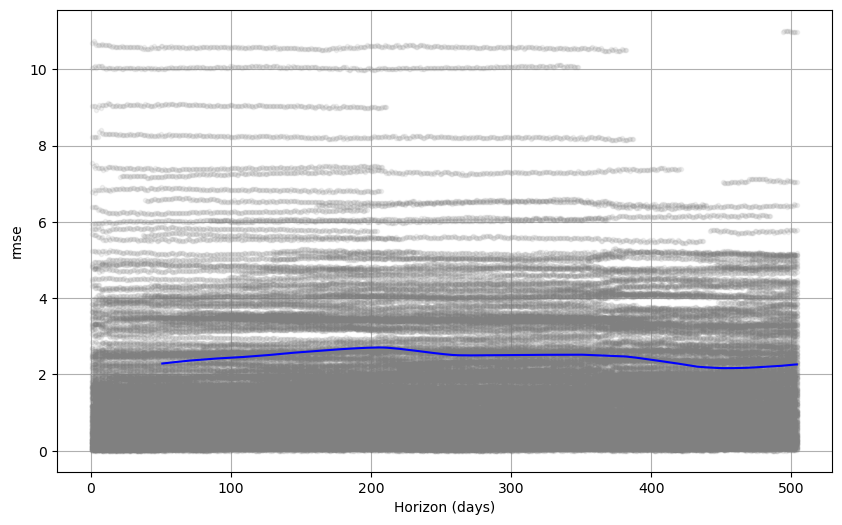

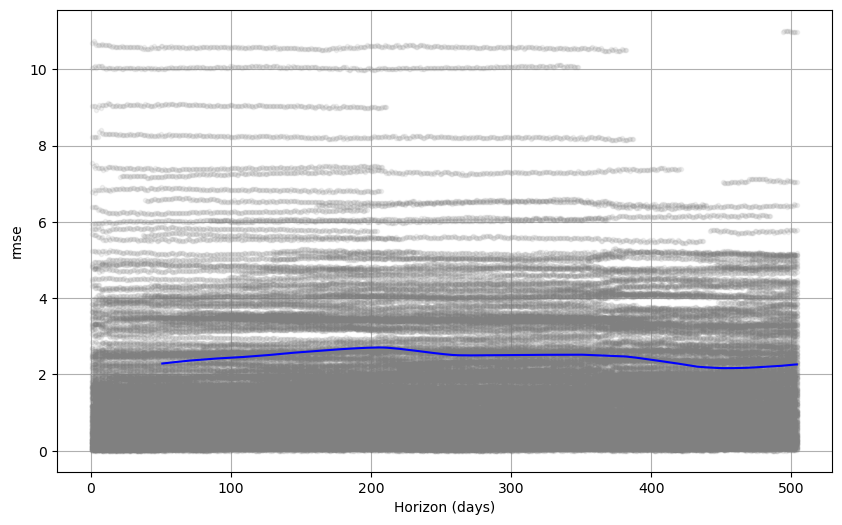

In [ ]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv,metric='rmse')

The Horizon (days) on the x-axis represents the number of days ahead for the prediction, while the rmse on the y-axis shows the error magnitude. The blue line gives the average RMSE for each horizon, and the gray dots represent the RMSE for individual predictions at different points in time.
##### Analysis
From the plot, it can be infered that:
- The average RMSE, illustrated by the blue line, remains relatively low and stable across the forecast horizons. This suggests that the model’s predictions are generally consistent in quality over time.
- There's no clear upward or downward trend in the RMSE over different horizons, which is good; it means the error doesn't increase dramatically as the forecast extends further into the future.
- The density of the gray dots near the bottom of the chart suggests that most of the individual forecast errors are relatively low, which indicates good predictive performance.

In conclusion, this plot shows that the forecasting model performs consistently across different forecast horizons, maintaining a steady level of error, which suggests reliability in the model's predictions. The absence of an increasing trend in RMSE over the horizon is a positive sign, indicating that the model’s performance does not degrade significantly over time.

In [ ]:
# # Merge the actual and predicted data on the 'ds' column
# merged_df = prediction[['ds', 'yhat']].merge(prophet_df[['ds', 'y']], on='ds', how='left')

# # Plotting
# plt.figure(figsize=(16, 8))
# plt.plot(merged_df['ds'], merged_df['y'], label='Actual Close Shift', color='blue')
# plt.plot(merged_df['ds'], merged_df['yhat'], label='Predicted Close Shift', color='red')
# plt.title('Actual vs Predicted Close Shifts')
# plt.xlabel('Date')
# plt.ylabel('Close Price Change (USD)')
# plt.legend()
# plt.grid(True)
# plt.show()


### Finding the best Hyperparameter for the model to reduce RMSE

In [ ]:
import itertools
import pandas as pd

# Assuming 'df' is already loaded and preprocessed as your time series dataframe
# Define the parameter grid to test different configurations
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# Use cross-validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.fit(df_train)  # fit the model with the given parameters
    df_cv = cross_validation(m, initial='2013 days', period='1 days', horizon='504 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].mean())

# Combine the parameters and their corresponding RMSEs into a DataFrame
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Find the best parameter combination
best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]
print("Best Parameters:", best_params)


15:45:06 - cmdstanpy - INFO - Chain [1] start processing
15:45:06 - cmdstanpy - INFO - Chain [1] done processing
15:47:18 - cmdstanpy - INFO - Chain [1] start processing
15:47:18 - cmdstanpy - INFO - Chain [1] done processing
15:49:29 - cmdstanpy - INFO - Chain [1] start processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing
15:51:54 - cmdstanpy - INFO - Chain [1] start processing
15:51:54 - cmdstanpy - INFO - Chain [1] done processing
15:54:17 - cmdstanpy - INFO - Chain [1] start processing
15:54:17 - cmdstanpy - INFO - Chain [1] done processing
15:55:36 - cmdstanpy - INFO - Chain [1] start processing
15:55:37 - cmdstanpy - INFO - Chain [1] done processing
15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:55 - cmdstanpy - INFO - Chain [1] done processing
15:58:14 - cmdstanpy - INFO - Chain [1] start processing
15:58:14 - cmdstanpy - INFO - Chain [1] done processing
15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1]

Best Parameters: changepoint_prior_scale    0.010000
seasonality_prior_scale    0.010000
rmse                       2.455168
Name: 4, dtype: float64


In [ ]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  2.458578
1                     0.001                     0.10  2.458829
2                     0.001                     1.00  2.459125
3                     0.001                    10.00  2.458591
4                     0.010                     0.01  2.455168
5                     0.010                     0.10  2.455751
6                     0.010                     1.00  2.455759
7                     0.010                    10.00  2.455726
8                     0.100                     0.01  2.458356
9                     0.100                     0.10  2.458920
10                    0.100                     1.00  2.459016
11                    0.100                    10.00  2.458994
12                    0.500                     0.01  2.465027
13                    0.500                     0.10  2.465693
14                    0.500                     1.00  2

### Checking Volatility of data for RMSE justification

In [162]:
print(cv['y'].describe())

count    139389.000000
mean          0.190829
std           2.437179
min         -10.519997
25%          -1.029999
50%           0.167496
75%           1.599991
max          11.110001
Name: y, dtype: float64


#### 1. Analyse the scale of the data
Examine the scale of 'Close' prices to see how the RMSE compares

In [ ]:
print(df['Close Shift'].describe())

count    2516.000000
mean        0.067452
std         1.752407
min       -10.519997
25%        -0.400002
50%         0.031072
75%         0.532500
max        12.000000
Name: Close Shift, dtype: float64


#### 2. Calculate the daily returns and their standard deviation to quantify volatility
The standard deviation of the daily returns gives a measure of how much the stock price fluctuates on a day-to-day basis.

In [161]:
print("Standard Deviation of Daily Price Changes: ", df['Close Shift'].std())

Standard Deviation of Daily Price Changes:  1.7524067535727774


#### 3. Check for Outliers
Identify if there are any outliers in the 'Close' prices which could affect the RMSE

In [ ]:
# Assuming 'df' is your DataFrame and 'Close Shift' is your column of interest
Q1 = df['Close Shift'].quantile(0.25)
Q3 = df['Close Shift'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Close Shift'] < lower_bound) | (df['Close Shift'] > upper_bound)]
print("Number of outliers:", len(outliers))
print(outliers)

Number of outliers: 438
           Date       Close  Close Shift
1002 2018-02-02   40.125000    -1.820000
1037 2018-03-26   43.192501     1.957500
1126 2018-08-01   50.375000     2.802502
1175 2018-10-10   54.090000    -2.627499
1185 2018-10-24   53.772499    -1.910000
...         ...         ...          ...
2501 2024-01-19  191.559998     2.929993
2502 2024-01-22  193.889999     2.330002
2508 2024-01-30  188.039993    -3.690002
2509 2024-01-31  184.399994    -3.639999
2510 2024-02-01  186.860001     2.460007

[438 rows x 3 columns]


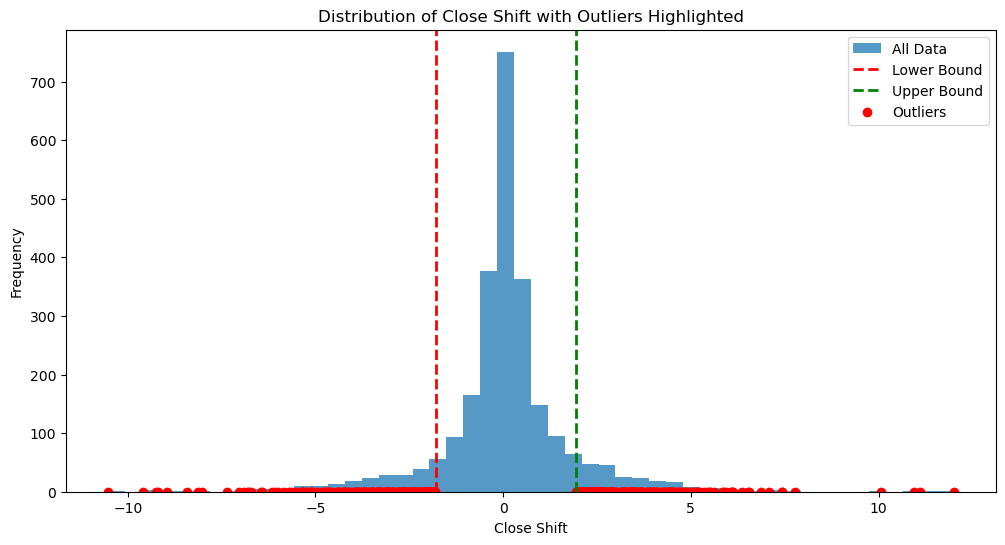

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.hist(df['Close Shift'], bins=50, alpha=0.75, label='All Data')
plt.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2, label='Lower Bound')
plt.axvline(x=upper_bound, color='g', linestyle='dashed', linewidth=2, label='Upper Bound')
plt.scatter(outliers['Close Shift'], np.zeros(len(outliers)), color='red', label='Outliers')
plt.legend()
plt.title('Distribution of Close Shift with Outliers Highlighted')
plt.xlabel('Close Shift')
plt.ylabel('Frequency')
plt.show()


## Loading the Model


In [ ]:
import joblib

# Save the model
joblib.dump(model, 'stock_prophet_model.pkl')

['stock_prophet_model.pkl']